In [20]:
import os
import glob

def get_image_types(basedir):
    return [img_type for img_type in os.listdir(basedir) if img_type != '.DS_Store']    

def get_car_images():
    basedir = 'vehicles/'
    cars = []
    for imtype in get_image_types(basedir):
        cars.extend(glob.glob(basedir + imtype+'/*'))
    return cars

def get_non_vehicle_images():
    basedir = 'non-vehicles/'
    nonvehicles = []
    for imtype in get_image_types(basedir):
        nonvehicles.extend(glob.glob(basedir + imtype+'/*'))
    return nonvehicles
    
def show_data_inspection():
    cars = get_car_images()
    nonvehicles = get_non_vehicle_images()
    
    print("Number of vehicle images:" + str(len(cars)))
    print("Number of non-vehicle images:" + str(len(nonvehicles)))
    
show_data_inspection()

Number of vehicle images:8792
Number of non-vehicle images:8968


In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [22]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(
            cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features
#Change transform_sqrt to False

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)

    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True,
                    vis=False,is_img_path=True):
        img_features = []

        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_features)

        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)

        if hog_feat == True:

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                if vis==True:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)                    
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features) 
            
        if vis==True:
            return np.concatenate(img_features), hog_image
        else:
            return np.concatenate(img_features)
        
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):
    features = []

    for img in imgs:
#         img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
#                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
#                                           cell_per_block=2, hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                                           hist_feat=hist_feat, hog_feat=hog_feat,vis=vis)

        img_features = []
        
        image = mpimg.imread(img)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_features)

        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)

        if hog_feat == True:

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy



def search_windows(img, windows, clf, scaler, color_space='RGB',
                  spatial_size=(32,32), hist_bins=32,
                  hist_range=(0,256), orient=9,
                  pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
    on_windows=[]
    
    for window in windows:
        test_img = cv2.resize(img[ window[0][1]:window[1][1], window[0][0]:window[1][0] ], (64,64))
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell = pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

        test_features=scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows 

def visualize(fig,rows,cols,imgs,titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='gray')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


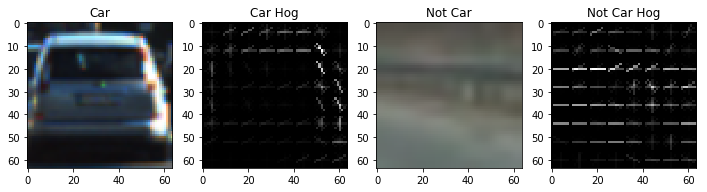

In [23]:
%matplotlib inline

cars = get_car_images()
notcars = get_non_vehicle_images()

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))


car_file = cars[car_ind]
notcar_file = notcars[notcar_ind]

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'RGB' #RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #0,1,2 or 'ALL'
spatial_size=(16,16) #Spatial binning dimensions
hist_bins=16 # Number of histogram bins
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["Car", "Car Hog", "Not Car", "Not Car Hog"]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [25]:
cars = get_car_images()
notcars = get_non_vehicle_images()

car_file = cars[car_ind]
notcar_file = notcars[notcar_ind]

color_space = 'YCrCb' #RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #0,1,2 or 'ALL'
spatial_size=(32,32) #Spatial binning dimensions
hist_bins=32 # Number of histogram bins
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

test_cars = cars
test_notcars = notcars


car_features = extract_features(test_cars, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=False)

notcar_features = extract_features(test_notcars, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=False)
print(time.time() - t, 'Seconds to compute features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state=np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print("Using:", orient, " orientations,",
     pix_per_cell, " pixels per cell,",
     cell_per_block, " cells per block,",
     hist_bins, " histogram bins and ",
     spatial_size, " spatial sampling")

print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), " Seconds to train SVC")

print('Test accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

144.08731198310852 Seconds to compute features...
Using: 9  orientations, 8  pixels per cell, 2  cells per block, 32  histogram bins and  (32, 32)  spatial sampling
Feature vector length: 8460
29.71  Seconds to train SVC
Test accuracy of SVC:  0.9899


0.0 1.0
0.9500210285186768  seconds  to process one image search 100  windows
0.0 1.0
0.8991971015930176  seconds  to process one image search 100  windows
0.0 1.0
0.8287169933319092  seconds  to process one image search 100  windows
0.0 1.0
1.3030519485473633  seconds  to process one image search 100  windows
0.0 1.0
0.9849178791046143  seconds  to process one image search 100  windows
0.0 1.0
0.7965278625488281  seconds  to process one image search 100  windows


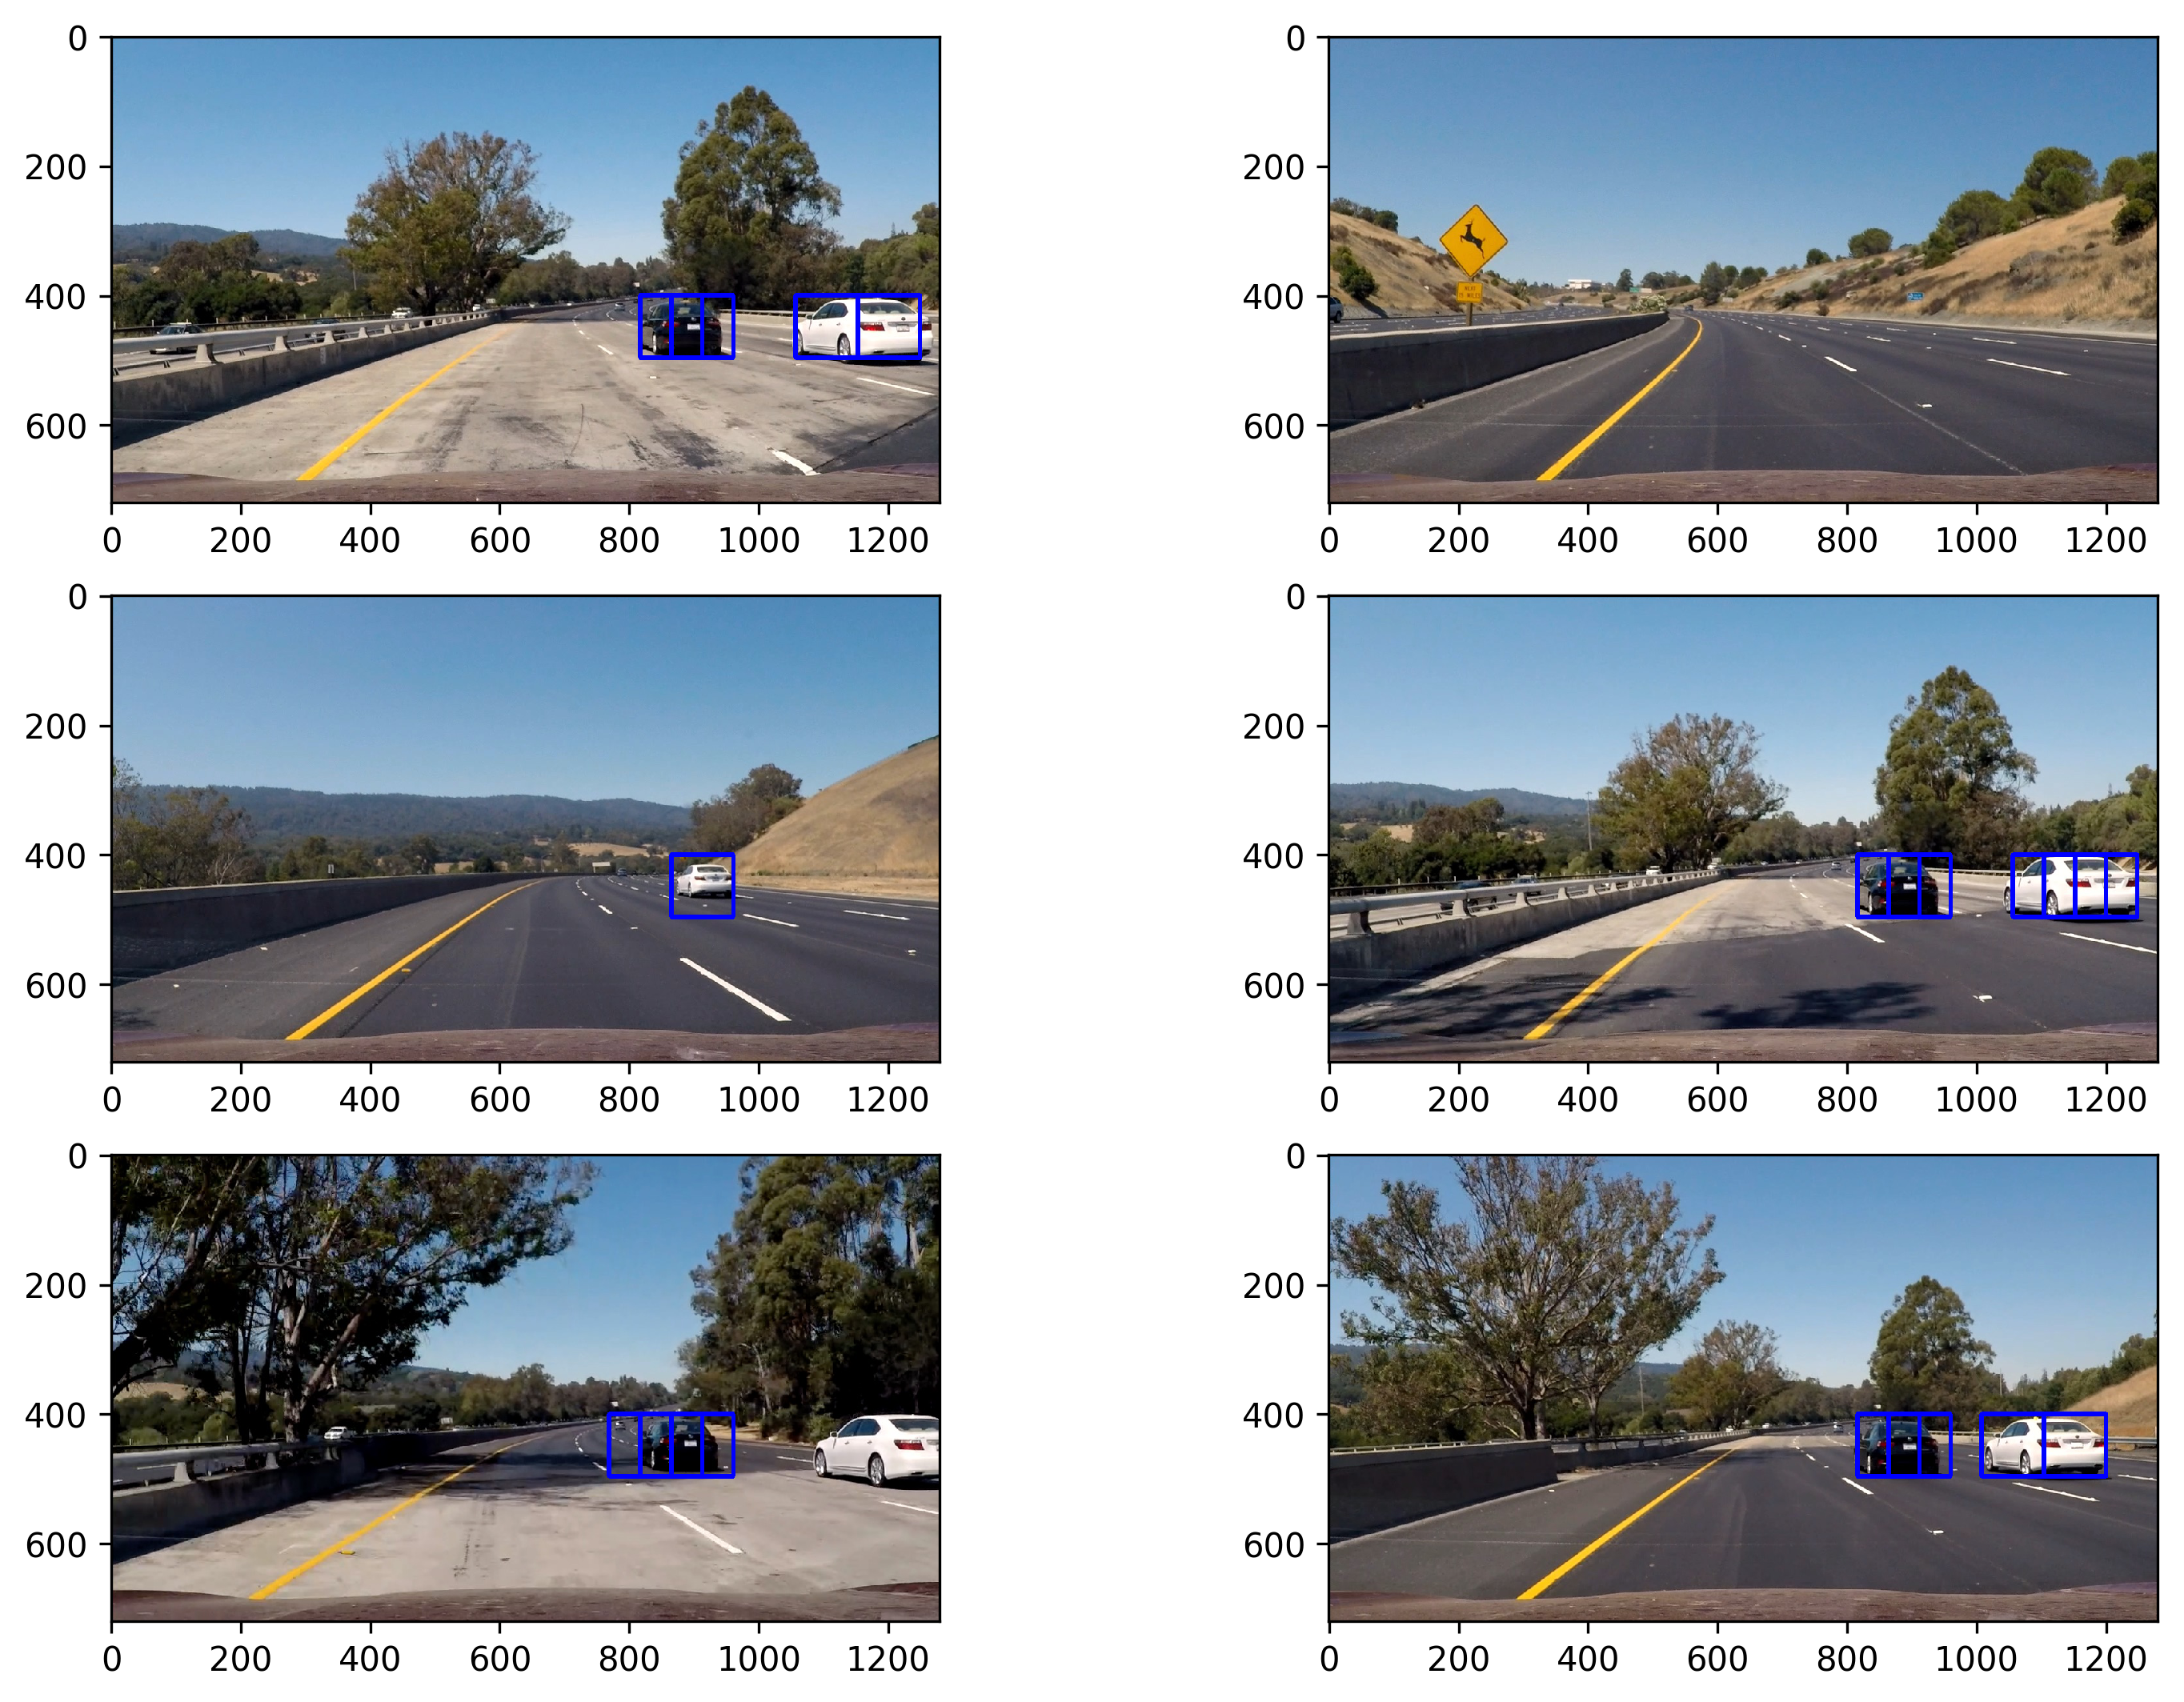

In [26]:
search_path = 'test_images/*.jpg'
example_images = glob.glob(search_path)

images = []
titles = []

y_start_stop = [400, 656]
overlap = 0.5

for img_src in example_images:
    t1 = time.time()

    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # Trained on png but reading in jpg so convert.
    print(np.min(img), np.max(img))
    
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96,96), xy_overlap=(overlap, overlap))



    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0 , 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t1, ' seconds  to process one image search', len(windows), ' windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 6, 2, images, titles)
    


In [27]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

0.7094929218292236  seconds to run , total windows:  294
0.6900811195373535  seconds to run , total windows:  294
0.6931591033935547  seconds to run , total windows:  294
0.684816837310791  seconds to run , total windows:  294
0.6686367988586426  seconds to run , total windows:  294
0.6900520324707031  seconds to run , total windows:  294


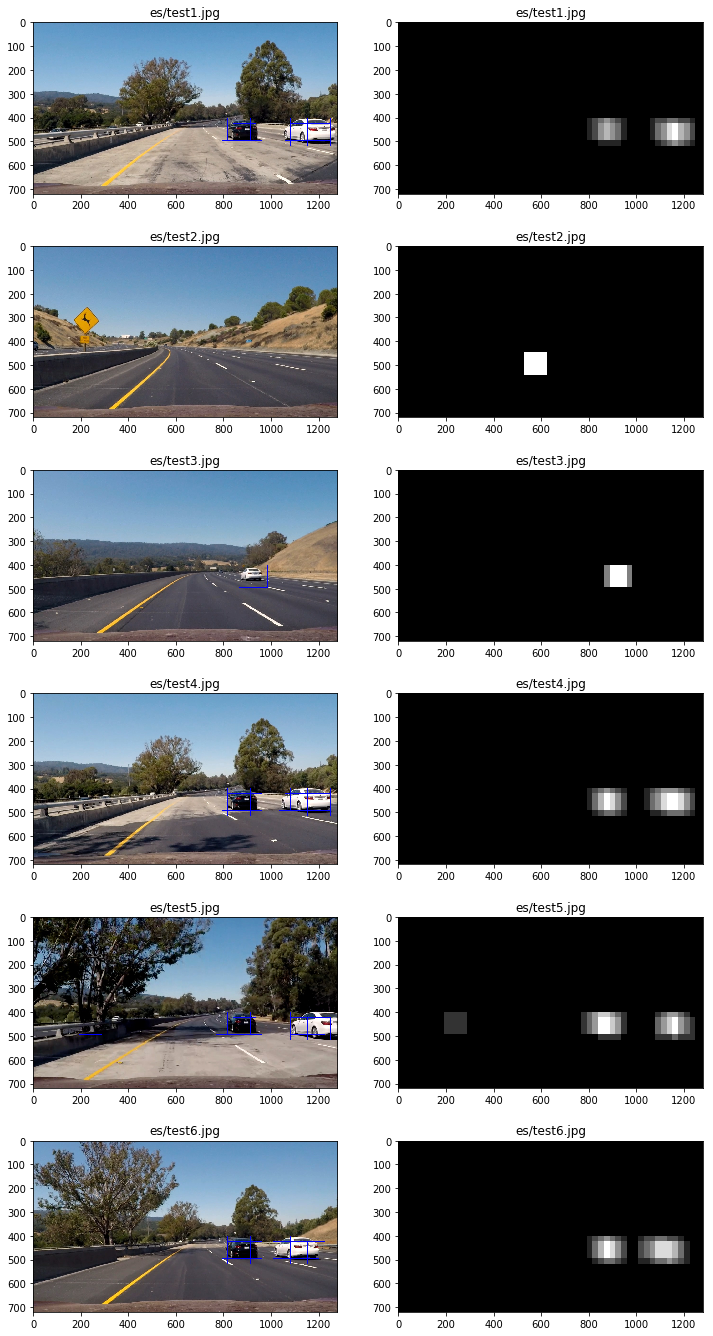

In [28]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
 
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            #Extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            #Get Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)) )
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    print(time.time() - t, ' seconds to run , total windows: ', count)
    
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])

    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)


fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)

In [29]:
def find_cars(img, scale):
    count = 0
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
 
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            #Extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            #Get Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)) )
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

In [30]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):

        nonzero = (labels[0] == car_number).nonzero()

        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

    return img

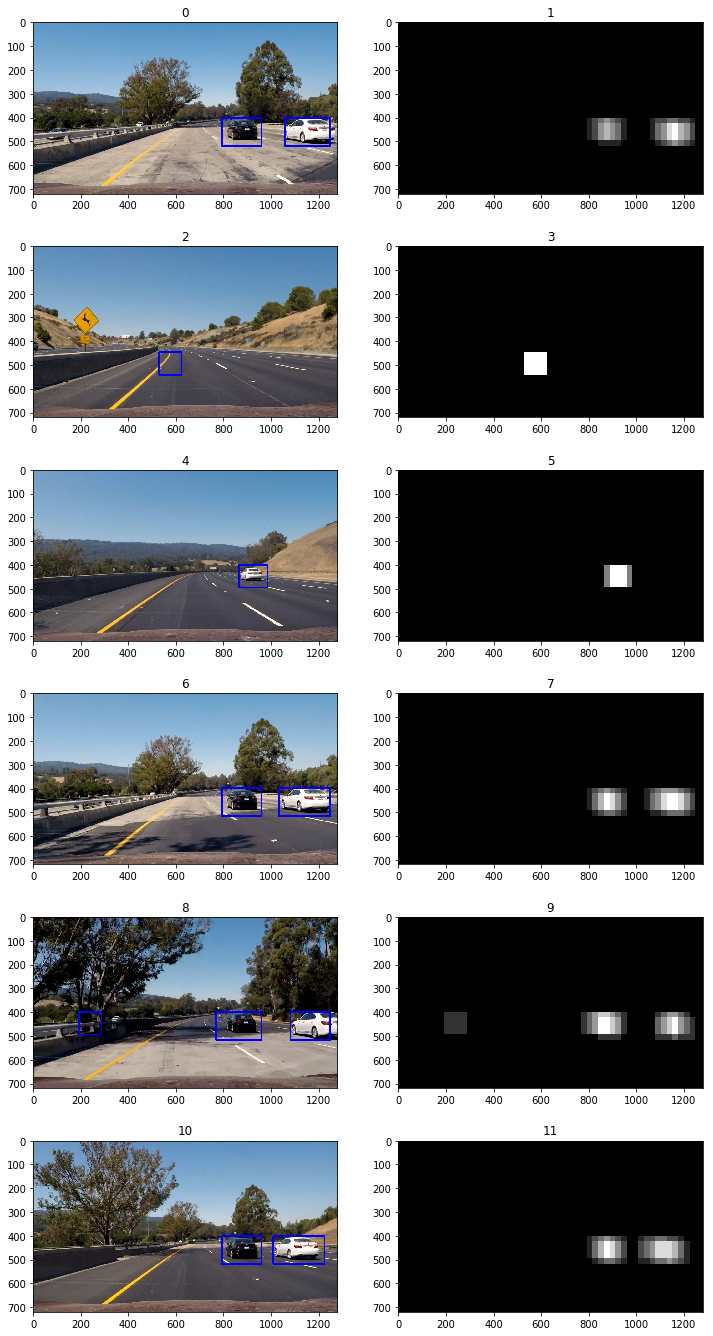

In [37]:
out_images = []
out_maps = []
out_titles = range(len(example_images) * 2)

ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 6,2, out_images, out_titles)

In [117]:
# def process_image(img):
#     out_img, heat_map = find_cars(img, scale)
#     labels = label(heat_map)
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     return draw_img

In [118]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# test_output = 'test.mp4'
# clip = VideoFileClip("project_video.mp4")
# test_clip = clip.fl_image(process_image)

# test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [15:30<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

